In [2]:
# Step 1 : Load data into pandas and take a peek. Try to understand the data (using provided data dictionary)
import pandas as pd

#since url for csv is not available reading from local system
##Note: this will not work on any system other than on which it is created

lcdata_raw = pd.read_csv("C:/Users/vinee/Downloads/loan/loan.csv")


lcdata_raw.info()

lcdata_raw.head(5)


D:\Upgrad\MLSoftware\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


#### Step 2: Data Cleaning (Pre processing before performing EDA)
 On viewing some rows accross all columns (in excel) and after reading through the data dictionary, 
 there are some action items identified
 1. We will keep only relevant columns out of 111 as EDA would be performed on only a subset of columns. 
    Columns like url, id, member_id, issue_d, desc, purpose, title etc provide no analytical value.
    Also after thinking through the business domain, we have decided to keep only those atributes which we believe have
    an impact on loan repayment ability of a person. Eg dti has an impact as people with low dti are not financially
    stressed and probably will repay the loan.
 2. We have encountered some inconsistency with the data provided. int_rate which is a crucial metric contains '%' 
    and hence pandas cannot identify it as a float value. Another such example is emp_length which has symbols like 
    '+','<', 'year' and 'years' appended to the number which we want to use for analysis. These need to be fixed
 3. We have also seen null values in the data set. We have to handle them appropriately both row and column wise. We are
    arbitralily choosing 30% as a threshold for working on null values. Meaning if any row/column has more than 30% null values 
    that row/column will be discarded. For the rows/column less than this threshold, we will fil the null values with 
    <b>mean/median/mode</b> depending on the type of variable. <i>Thumbrule is for continuous variable we use either mean or median 
    (if outliers are there we will use median to ignore outlier values). For categorical (discreet) columns we will use mode.</i>
 4. The analysis will be performed only on customer data for which we have a conclusion i.e either it is a default or repaid
    without any issues. This was also discussed in the live session.
 5. We will make use of visualization in pandas to find and impute outlier entries


In [7]:
#Step 2 - Implementation
#2.1 We chunk out the relevant columns based on our understanding of the business domain. Note - It is possible that some
#    of these columns have to be discarded if they have more than 30% missing values. We will find this soon.
lcdata_raw_filter = lcdata_raw[['loan_amnt','term','int_rate','grade','sub_grade','emp_length','home_ownership',
                        'annual_inc','loan_status','purpose','zip_code','dti','earliest_cr_line','inq_last_6mths',
                               'pub_rec','total_acc','application_type','annual_inc_joint','dti_joint','il_util',
                               'pub_rec_bankruptcies','tax_liens','num_op_rev_tl']]

#2.2 We filter out all current customers whose installments are ongoing since we don't know if it as good or bad customer

lcdata_raw_closed = lcdata_raw_filter [(lcdata_raw_filter["loan_status"].isin(["Charged Off","Fully Paid"]))]

lcdata_raw_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   term                  38577 non-null  object 
 2   int_rate              38577 non-null  object 
 3   grade                 38577 non-null  object 
 4   sub_grade             38577 non-null  object 
 5   emp_length            37544 non-null  object 
 6   home_ownership        38577 non-null  object 
 7   annual_inc            38577 non-null  float64
 8   loan_status           38577 non-null  object 
 9   purpose               38577 non-null  object 
 10  zip_code              38577 non-null  object 
 11  dti                   38577 non-null  float64
 12  earliest_cr_line      38577 non-null  object 
 13  inq_last_6mths        38577 non-null  int64  
 14  pub_rec               38577 non-null  int64  
 15  total_acc          

In [26]:
#2.3 We have to sanitise the data by removing null and fixing data formatting issues

    #2.3.1 Remove '%' symbol from int_rate and convert to float
    

lcdata_raw_closed['int_rate'] = lcdata_raw_closed['int_rate'].astype(str).str.replace("%", "").astype(float)

lcdata_raw_closed.head()



C:\Users\vinee\AppData\Local\Temp/ipykernel_25312/3395775672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdata_raw_closed['int_rate'] = lcdata_raw_closed['int_rate'].astype(str).str.replace("%", "").astype(float)


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,purpose,...,inq_last_6mths,pub_rec,total_acc,application_type,annual_inc_joint,dti_joint,il_util,pub_rec_bankruptcies,tax_liens,num_op_rev_tl
0,5000,36,10.65,B,B2,10,RENT,24000.0,Fully Paid,credit_card,...,1,0,9,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
1,2500,60,15.27,C,C4,1,RENT,30000.0,Charged Off,car,...,5,0,4,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
2,2400,36,15.96,C,C5,10,RENT,12252.0,Fully Paid,small_business,...,2,0,10,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
3,10000,36,13.49,C,C1,10,RENT,49200.0,Fully Paid,other,...,1,0,37,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
5,5000,36,7.90,A,A4,3,RENT,36000.0,Fully Paid,wedding,...,3,0,12,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN


In [27]:
    #2.3.2 convert emp_length into integer
def emp_length_to_number(s) :
        if('<' in s):
            return 1
        elif('1 year' in s):
            return 1
        elif('+' in s):
            return 10    
        else:
            return s.split("years")[0].strip()
         
lcdata_raw_closed['emp_length'] = lcdata_raw_closed['emp_length'].astype(str).apply(lambda x: emp_length_to_number(x))

lcdata_raw_closed['emp_length'] = lcdata_raw_closed['emp_length'].str.replace("nan","0") 
#we are setting nulls to 0, later we will find the mean of emp_length and replace 0 with mean/median

lcdata_raw_closed['emp_length'] = pd.to_numeric(lcdata_raw_closed['emp_length'])

lcdata_raw_closed.emp_length.unique()

C:\Users\vinee\AppData\Local\Temp/ipykernel_25312/2369843479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdata_raw_closed['emp_length'] = lcdata_raw_closed['emp_length'].astype(str).apply(lambda x: emp_length_to_number(x))
C:\Users\vinee\AppData\Local\Temp/ipykernel_25312/2369843479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdata_raw_closed['emp_length'] = lcdata_raw_closed['emp_length'].str.replace("nan","0")
C:\Users\vinee\AppData\Local\Temp/ipykernel_25312/2369843479.py:17: SettingW

array([10,  1,  3,  8,  9,  4,  5,  6,  2,  7,  0], dtype=int64)

In [28]:
   #2.3.3 remove 'months' from term and change it to int type

lcdata_raw_closed['term'] = lcdata_raw_closed['term'].astype(str).str.replace("months", "").astype(int)
    
lcdata_raw_closed.head()

C:\Users\vinee\AppData\Local\Temp/ipykernel_25312/910982678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcdata_raw_closed['term'] = lcdata_raw_closed['term'].astype(str).str.replace("months", "").astype(int)


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,purpose,...,inq_last_6mths,pub_rec,total_acc,application_type,annual_inc_joint,dti_joint,il_util,pub_rec_bankruptcies,tax_liens,num_op_rev_tl
0,5000,36,10.65,B,B2,10,RENT,24000.0,Fully Paid,credit_card,...,1,0,9,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
1,2500,60,15.27,C,C4,1,RENT,30000.0,Charged Off,car,...,5,0,4,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
2,2400,36,15.96,C,C5,10,RENT,12252.0,Fully Paid,small_business,...,2,0,10,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
3,10000,36,13.49,C,C1,10,RENT,49200.0,Fully Paid,other,...,1,0,37,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN
5,5000,36,7.90,A,A4,3,RENT,36000.0,Fully Paid,wedding,...,3,0,12,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,NaN


In [34]:
  #2.3.4 remove all colums and rows which have more than 30% null values
  
lcdata_raw_closed.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
grade                       0
sub_grade                   0
emp_length                  0
home_ownership              0
annual_inc                  0
loan_status                 0
purpose                     0
zip_code                    0
dti                         0
earliest_cr_line            0
inq_last_6mths              0
pub_rec                     0
total_acc                   0
application_type            0
annual_inc_joint        38577
dti_joint               38577
il_util                 38577
pub_rec_bankruptcies      697
tax_liens                  39
num_op_rev_tl           38577
dtype: int64

In [ ]:
# We see that almost 100% entries in annual_inc_joint, dti_joint, il_util and num_op_rev_tl columns are null. 
# This gives us insight that the number of joint applicants are negligible. Another thing we can observe is there are
# no rows where more than 30% columns (6 out of 19) could be null. So we do not need to scan rows for nulls
# We will remove all these columns
    
lc_data_refined_columns = lcdata_raw_closed.drop(['annual_inc_joint', 'dti_joint', 'il_util', 'num_op_rev_tl'], axis = 1)

lc_data_refined_columns.tail()

In [61]:
    # 2.3.5
# We will use zip_code as unordered catergorical variable. The idea is to find whether a certain zipcode is showing high number 
# of defaults. For this purpose we will trim the 'xx' from zip code and just keep first 3 digits

lc_data_refined_columns['zip_code'] = lc_data_refined_columns['zip_code'].astype(str).str.replace("xx","").astype(str)
lc_data_refined_columns.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,earliest_cr_line,inq_last_6mths,pub_rec,total_acc,application_type,pub_rec_bankruptcies
0,5000,36,10.65,B,B2,10,RENT,24000.0,Fully Paid,credit_card,860,27.65,Jan-85,1,0,9,INDIVIDUAL,0.0
1,2500,60,15.27,C,C4,1,RENT,30000.0,Charged Off,car,309,1.00,Apr-99,5,0,4,INDIVIDUAL,0.0
2,2400,36,15.96,C,C5,10,RENT,12252.0,Fully Paid,small_business,606,8.72,Nov-01,2,0,10,INDIVIDUAL,0.0
3,10000,36,13.49,C,C1,10,RENT,49200.0,Fully Paid,other,917,20.00,Feb-96,1,0,37,INDIVIDUAL,0.0
5,5000,36,7.90,A,A4,3,RENT,36000.0,Fully Paid,wedding,852,11.20,Nov-04,3,0,12,INDIVIDUAL,0.0


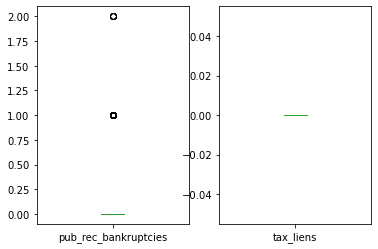

In [36]:
#2.4 Impute the missing data for applicable columns.
#    We see that our dataset has only 2 columns with null values pub_rec_bankruptcies - 697 and tax_liens -39
#    We will draw a boxplot to see how the data is distributed so that we can choose either mean or median to fill nulls

import matplotlib.pyplot as plt
lc_data_refined_columns[["pub_rec_bankruptcies", "tax_liens"]].plot(kind= "box", subplots= True)
plt.show()

# we will go with imputing 0 for pub_rec_bankruptcies and 0 for tax_liens. We also observed that the size of box is 
# negligible which indicates these is almost no variation in the value of these columns. These columns might not carry
# any value to solve our business problem.

In [37]:
# filling null values
lc_data_refined_columns['pub_rec_bankruptcies'] = lc_data_refined_columns['pub_rec_bankruptcies'].fillna(0)

lc_data_refined_columns['tax_liens'] = lc_data_refined_columns['tax_liens'].fillna(0)

In [38]:
lc_data_refined_columns[lc_data_refined_columns['tax_liens'] >0 ]

# It is better to drop the column 'tax_liens' as after imputation all values are 0

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,earliest_cr_line,inq_last_6mths,pub_rec,total_acc,application_type,pub_rec_bankruptcies,tax_liens


In [ ]:
lc_data_refined_columns = lc_data_refined_columns.drop(['tax_liens'], axis = 1)

In [ ]:
# We need to take care of the 0s we used in place of null values for emp_length
lc_data_refined_columns[lc_data_refined_columns['emp_length'] == 0 ]

#There are 1033 rows with emp_length = 0

In [49]:
print(lc_data_refined_columns['emp_length'].mean())
print(lc_data_refined_columns['emp_length'].median())
print(lc_data_refined_columns['emp_length'].mode())

4.925525572232159
4.0
0    10
dtype: int64


In [59]:
#How the dataframe is looking after clean up
lc_data_refined_columns.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,dti,earliest_cr_line,inq_last_6mths,pub_rec,total_acc,application_type,pub_rec_bankruptcies
0,5000,36,10.65,B,B2,10,RENT,24000.0,Fully Paid,credit_card,860,27.65,Jan-85,1,0,9,INDIVIDUAL,0.0
1,2500,60,15.27,C,C4,1,RENT,30000.0,Charged Off,car,309,1.00,Apr-99,5,0,4,INDIVIDUAL,0.0
2,2400,36,15.96,C,C5,10,RENT,12252.0,Fully Paid,small_business,606,8.72,Nov-01,2,0,10,INDIVIDUAL,0.0
3,10000,36,13.49,C,C1,10,RENT,49200.0,Fully Paid,other,917,20.00,Feb-96,1,0,37,INDIVIDUAL,0.0
5,5000,36,7.90,A,A4,3,RENT,36000.0,Fully Paid,wedding,852,11.20,Nov-04,3,0,12,INDIVIDUAL,0.0


In [62]:
#How the dataframe is looking after clean up
lc_data_refined_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   term                  38577 non-null  int32  
 2   int_rate              38577 non-null  float64
 3   grade                 38577 non-null  object 
 4   sub_grade             38577 non-null  object 
 5   emp_length            38577 non-null  int64  
 6   home_ownership        38577 non-null  object 
 7   annual_inc            38577 non-null  float64
 8   loan_status           38577 non-null  object 
 9   purpose               38577 non-null  object 
 10  zip_code              38577 non-null  object 
 11  dti                   38577 non-null  float64
 12  earliest_cr_line      38577 non-null  object 
 13  inq_last_6mths        38577 non-null  int64  
 14  pub_rec               38577 non-null  int64  
 15  total_acc          

In [52]:
# we will replace 0 values in emp_length with median value 4 
lc_data_refined_columns['emp_length'] = lc_data_refined_columns['emp_length'].apply(lambda x: 4 if x==0 else x)

lc_data_refined_columns.emp_length.unique()

# Now we are ready to do EDA

array([10,  1,  3,  8,  9,  4,  5,  6,  2,  7], dtype=int64)

### Step 3 - EDA
## Step 3.1 - Univariate analysis
##### Ideas - We will plot histograms for columns like emp_length, grade, term etc to see pattern in the data. This might not give any conclusions but will enable us to proceed to the solution

In [63]:
# let's describe the data frame as we have cleaned the data
lc_data_refined_columns.describe()
# We can conclude that mean and median for int_rate and dti are almost same

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,pub_rec_bankruptcies
count,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000
mean,11047.025430,41.898437,11.932219,5.032636,6.877797e+04,13.272727,0.871737,0.055422,22.052648,0.042694
std,7348.441646,10.333136,3.691327,3.360263,6.421868e+04,6.673044,1.071546,0.237804,11.425861,0.202809
min,500.000000,36.000000,5.420000,1.000000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000
25%,5300.000000,36.000000,8.940000,2.000000,4.000000e+04,8.130000,0.000000,0.000000,13.000000,0.000000
50%,9600.000000,36.000000,11.710000,4.000000,5.886800e+04,13.370000,1.000000,0.000000,20.000000,0.000000
75%,15000.000000,36.000000,14.380000,9.000000,8.200000e+04,18.560000,1.000000,0.000000,29.000000,0.000000
max,35000.000000,60.000000,24.400000,10.000000,6.000000e+06,29.990000,8.000000,4.000000,90.000000,2.000000


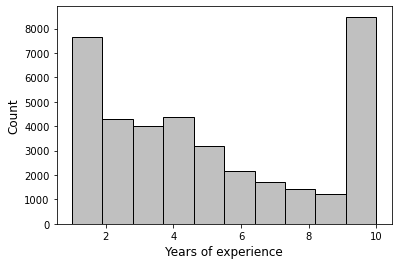

In [65]:
# Let's draw a histogram to identify patterns for certain attributes

plt.hist(lc_data_refined_columns['emp_length'], bins = 10,edgecolor='Black',color='silver')
plt.xlabel("Years of experience", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})
plt.ylabel("Count", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})

plt.show()

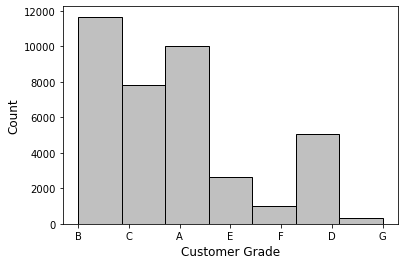

In [68]:
plt.hist(lc_data_refined_columns['grade'], bins = 7,edgecolor='Black',color='silver')
plt.xlabel("Customer Grade", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})
plt.ylabel("Count", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})

plt.show()

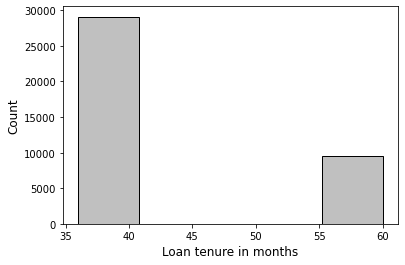

In [72]:
plt.hist(lc_data_refined_columns['term'], bins = 5,edgecolor='Black',color='silver')
plt.xlabel("Loan tenure in months", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})
plt.ylabel("Count", fontdict={'fontsize': 12, 'fontweight' : 8, 'color' : 'Black'})

plt.show()

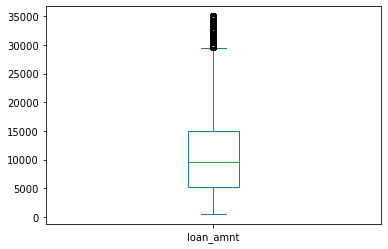

In [73]:
#draw box plot for loan amount
lc_data_refined_columns[["loan_amnt"]].plot(kind= "box", subplots= False)
plt.show()

# We have so many outliers so outlier teatment is required

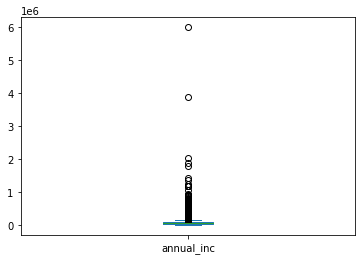

In [77]:
#draw box plot for annual income
lc_data_refined_columns[["annual_inc"]].plot(kind= "box", subplots= False)
plt.show()

# outlier treatment required

In [153]:
q95 = lc_data_refined_columns["annual_inc"].quantile(0.95)
p95 = lc_data_refined_columns[lc_data_refined_columns['annual_inc'] <= q95]

p_95.describe()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,inq_last_6mths,pub_rec,total_acc,pub_rec_bankruptcies
count,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000,36654.000000
mean,10682.249550,41.849075,11.888080,4.994462,60855.751621,13.446725,0.864108,0.056829,21.641349,0.043897
std,7048.414166,10.303835,3.667257,3.347489,27750.284125,6.661899,1.064146,0.240307,11.232836,0.205533
min,500.000000,36.000000,5.420000,1.000000,4000.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,5000.000000,36.000000,8.940000,2.000000,40000.000000,8.350000,0.000000,0.000000,13.000000,0.000000
50%,9250.000000,36.000000,11.710000,4.000000,56000.000000,13.580000,1.000000,0.000000,20.000000,0.000000
75%,15000.000000,36.000000,14.270000,8.000000,77970.500000,18.710000,1.000000,0.000000,28.000000,0.000000
max,35000.000000,60.000000,24.400000,10.000000,140004.000000,29.990000,8.000000,4.000000,90.000000,2.000000


In [144]:
print ("Average loan amount for defaulters -")
print(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin(['Charged Off'])].loan_amnt.mean())

print ("Average loan amount for fully paid customers -")
print(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin(['Fully Paid'])].loan_amnt.mean())

Average loan amount for defaulters -
12104.385107517328
Average loan amount for fully paid customers -
10866.455993930198


### Step 3.2 - Bivariate analysis
#### Ideas - We will use scatter plots to see relation between multiple attributes. Also we want to find if any two attributes have high positive or negative corelation

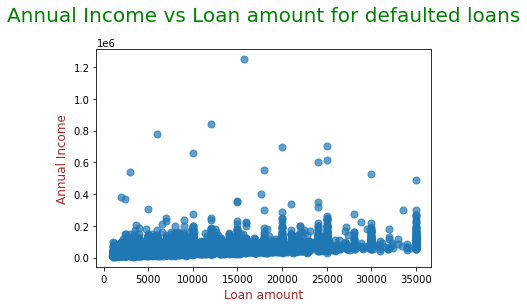

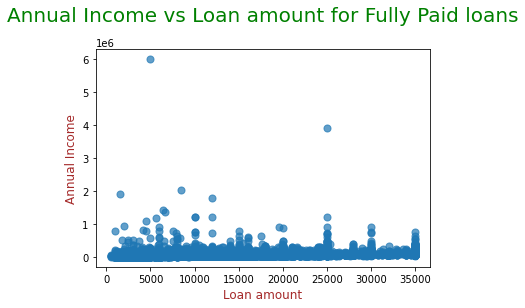

In [129]:
plt.scatter(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin (["Charged Off"])].loan_amnt, 
            lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin (["Charged Off"])].annual_inc, alpha= 0.7, s = 50 )

# Adding and formatting title
plt.title("Annual Income vs Loan amount for defaulted loans\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

# Labeling Axes
plt.ylabel("Annual Income", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("Loan amount", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})

plt.show()

plt.scatter(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin (["Fully Paid"])].loan_amnt, 
            lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin (["Fully Paid"])].annual_inc, alpha= 0.7, s = 50 )

#Fully Paid
# Adding and formatting title
plt.title("Annual Income vs Loan amount for Fully Paid loans\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})

# Labeling Axes
plt.ylabel("Annual Income", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("Loan amount", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})

plt.show()

Conclusion 1: Defaulters generally have a <b>lower annual income</b> in comparison to normal customers. Also we saw earlier that average loan amount of defaulter is higher than normal customer. Hence we conclude that <b>annual income is a very strong attribute to consider (especially for higher loan amounts)</b>

In [88]:
pd.pivot_table(lc_data_refined_columns, values='loan_amnt', index='purpose', columns=['loan_status'], aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)

loan_status,Charged Off,Fully Paid
purpose,,
car,7264.218750,6684.895444
credit_card,13014.944649,11396.967670
debt_consolidation,13517.925551,12319.847266
educational,7858.928571,6592.193309
home_improvement,11913.688761,11224.861551
house,12640.254237,12775.081169
major_purchase,9135.022523,7950.272303
medical,8568.396226,8040.608696
moving,5936.141304,6688.119835


Conclusion 2 - The riskiest of loan purpose is <b>small_business</b> followed by <b>debt_consolidation and credit_card</b>

In [135]:
pd.pivot_table(lc_data_refined_columns, values=['loan_amnt'], index='zip_code', columns=['loan_status'], aggfunc='count', sort=True)

loan_amnt           
loan_status Charged Off Fully Paid
zip_code                          
007                 NaN        1.0
010                14.0       84.0
011                 1.0       13.0
012                 1.0       12.0
013                 3.0       10.0
...                 ...        ...
995                 5.0       28.0
996                 2.0       10.0
997                 6.0       14.0
998                 NaN       10.0
999                 1.0        NaN

[822 rows x 2 columns]

If I could sort the above table we could find the zip code with highest number of defaults.

In [96]:
pd.pivot_table(lc_data_refined_columns, values=['loan_amnt'], index='grade', columns=['loan_status'], aggfunc='count')

loan_amnt           
loan_status Charged Off Fully Paid
grade                             
A                   602       9443
B                  1425      10250
C                  1347       6487
D                  1118       3967
E                   715       1948
F                   319        657
G                   101        198

Conclusion 3 - Based on the above table the % of default risk is increasing as category is decreasing. So we can conclude
                the grading system used by Loan Club is working almost accurately in real world.

In [102]:
pd.pivot_table(lc_data_refined_columns, values=['loan_amnt'], index='term', columns=['loan_status','grade'], aggfunc='count')

loan_amnt                                                      \
loan_status Charged Off                              Fully Paid               
grade                 A    B    C    D    E    F   G          A     B     C   
term                                                                          
36                  565  985  844  580  176   56  21       9085  8346  4905   
60                   37  440  503  538  539  263  80        358  1904  1582   

                                   
loan_status                        
grade           D     E    F    G  
term                               
36           2651   692  155   35  
60           1316  1256  502  163

Conclusion 4 - For Charged off category 42% people go for 60 month tenure. For fully paid loans only 21% opt for 60 month loan.<br> We can conclude that the lesser the loan tenure the better are chances of no default.

In [145]:
#dti analysis
print ("Average dti for defaulters -")
print(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin(['Charged Off'])].dti.mean())

print ("Average dti for fully paid customers -")
print(lc_data_refined_columns[lc_data_refined_columns['loan_status'].isin(['Fully Paid'])].dti.mean())


Average dti for defaulters -
14.00062377821221
Average dti for fully paid customers -
13.148421244309597


Conclusion 5 - DTI seems to have almost no effect on the loan paying capacity which is counterintutive.

In [147]:
print(lc_data_refined_columns['dti'].corr(lc_data_refined_columns['int_rate']))

0.11091283438288807


In [148]:
print(lc_data_refined_columns['annual_inc'].corr(lc_data_refined_columns['int_rate']))

0.048899125120824886


In [149]:
print(lc_data_refined_columns['annual_inc'].corr(lc_data_refined_columns['loan_amnt']))

0.2689993990756644


### Conclusion summary
- Conclusion 1 - annual income is a very strong attribute to consider (especially for higher loan amounts)
- Conclusion 2 - The riskiest of loan purpose is <b>small_business</b> followed by <b>debt_consolidation and credit_card</b>
- Conclusion 3 - Grading system used by Loan Club is working almost accurately in real world.
- Conclusion 4 - lesser the loan tenure the better are chances of no default.
- Conclusion 4 - DTI seems to have almost no effect on the loan paying capacity